### Import necessary libraries

In [195]:
import cv2
import skimage
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from skimage.segmentation import slic
from skimage.util import img_as_float
from scipy import ndimage as nd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os

### Feature Extraction Functions

In [196]:
import numpy as np
import pandas as pd
from skimage.segmentation import slic
from skimage import img_as_float
from scipy import ndimage as nd

def extract_features(image):
    X1 = extract_all(image)
    X2 = superpixel(image, False).reshape(-1, 1)
    X3 = extract_neighbors_features(image).reshape(-1, 1)

    # Print shapes for debugging
    print("X1 shape:", X1.shape)
    print("X2 shape:", X2.shape)
    print("X3 shape:", X3.shape)
    
    X = np.concatenate((X1, X2, X3), axis=1)
    return X

def superpixel(image, status):    
    if status:
        segments = slic(img_as_float(image), n_segments=100, sigma=5)
    else:
        segments = slic(img_as_float(image), n_segments=100, sigma=5, compactness=0.1, channel_axis=None) 

    return segments

def extract_neighbors_features(img, distance=8):
    if len(img.shape) > 2:
        height, width, _ = img.shape  # For colored images
        total_pixels = height * width
    else:
        height, width = img.shape  # For grayscale images
        total_pixels = img.size
        
    X = []

    for x in range(height):
        for y in range(width):
            neighbors = []
            for k in range(x - distance, x + distance + 1):
                for p in range(y - distance, y + distance + 1):
                    if x == k and p == y:
                        continue
                    elif 0 <= k < height and 0 <= p < width:
                        if len(img.shape) > 2:
                            neighbors.append(img[k, p])  # For colored images
                        else:
                            neighbors.append(img[k, p])  # For grayscale images
                    else:
                        neighbors.append(0)

            X.append(sum(neighbors) / len(neighbors))

    return np.array(X).reshape(total_pixels, -1)


def extract_all(img):
    if len(img.shape) > 2:
        # For colored images
        img2 = img.reshape(-1, img.shape[-1])  # Reshape to 2D array
    else:
        # For grayscale images
        img2 = img.reshape(-1, 1)  # Reshape to 2D array
    
    # First feature is gray value of each pixel
    df = pd.DataFrame()
    df['GrayValue(I)'] = img2.flatten()

    # Second feature is GAUSSIAN filter with sigma=3
    gaussian_img = nd.gaussian_filter(img, sigma=3)
    gaussian_img1 = gaussian_img.reshape(-1)
    df['Gaussian s3'] = gaussian_img1

    # Third feature is GAUSSIAN filter with sigma=7
    gaussian_img = nd.gaussian_filter(img, sigma=7)
    gaussian_img2 = gaussian_img.reshape(-1)
    df['Gaussian s7'] = gaussian_img2

    # Fourth feature is generic filter for variance of each pixel with size=3
    variance_img = nd.generic_filter(img, np.var, size=3)
    variance_img1 = variance_img.reshape(-1)
    df['Variance s3'] = variance_img1

    return df


### Setting constant variables

In [197]:
distance = 1
minImageIndex  = 1
maxImageIndex  = 50

### Functions and procedure for Training the model

In [198]:
import cv2
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
import os

# Function to convert colored images to grayscale
def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Function to load dataset (only colored images)
def load_dataset(dataset_path):
    colored_images = []
    
    for filename in os.listdir(dataset_path)[0:350]:
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Load colored image
            colored_image = cv2.imread(os.path.join(dataset_path, filename))
            #converting from BGR to RGB color space
            colored_image = cv2.cvtColor(colored_image, cv2.COLOR_BGR2RGB)
            colored_images.append(colored_image)
    
    return colored_images

# Function to extract features from a grayscale image
def extract_features(image):
    X1 = extract_all(image)
    X2 = superpixel(image, False).reshape(-1, 1)
    X3 = extract_neighbors_features(image).reshape(-1, 1)

    # Print shapes for debugging
    #print("X1 shape:", X1.shape)
    #print("X2 shape:", X2.shape)
    #print("X3 shape:", len(X3))
    X = np.c_[X1, X2, X3]
    return X

# Function to train the KNN model
def train_model(grayscale_images, colored_images):
    X_train = []
    y_train = []
    for grayscale_image, colored_image in zip(grayscale_images, colored_images):
        # Extract features from grayscale image
        grayscale_features = extract_features(grayscale_image)
        # Extract RGB values from colored image
        colored_rgb_values = colored_image.reshape(-1, 3)
        X_train.append(grayscale_features)
        y_train.append(colored_rgb_values)
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    knn_model = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
    knn_model.fit(X_train, y_train)
    return knn_model


# Function to colorize a grayscale image
def colorize_image(grayscale_image, knn_model):
    # Extract features from grayscale image
    grayscale_features = extract_features(grayscale_image)
    
    # Predict color values using the trained model
    predicted_colors = knn_model.predict(grayscale_features)
    # Reshape predicted colors to match the size of the grayscale image
    predicted_colors_reshaped = predicted_colors.reshape(grayscale_image.shape[0], grayscale_image.shape[1], -1)   

    # Check the number of channels in the predicted colors
    if predicted_colors_reshaped.shape[-1] == 1:
        # If the predicted colors have only one channel, convert to BGR
        colorized_image = cv2.cvtColor(predicted_colors_reshaped, cv2.COLOR_GRAY2BGR)
    elif predicted_colors_reshaped.shape[-1] == 3:
        # If the predicted colors have three channels, no need to convert
        colorized_image = predicted_colors_reshaped
    else:
        raise ValueError("Invalid number of channels in predicted colors")

        
    return colorized_image

In [199]:
#Model Training on a subset of our Dataset:
# Loading dataset 
dataset_path = r"C:\Users\hp\Downloads\LAU\Spring 2024\Data Science\project\data"
colored_images = load_dataset(dataset_path)

# Convert colored images to grayscale
grayscale_images = [convert_to_grayscale(image) for image in colored_images]

# Train the KNN model
knn_model = train_model(grayscale_images, colored_images)    

In [200]:
from joblib import dump, load

# Saving the knn model to use it later
dump(knn_model, 'knn_model.joblib')

['knn_model.joblib']

## Testing

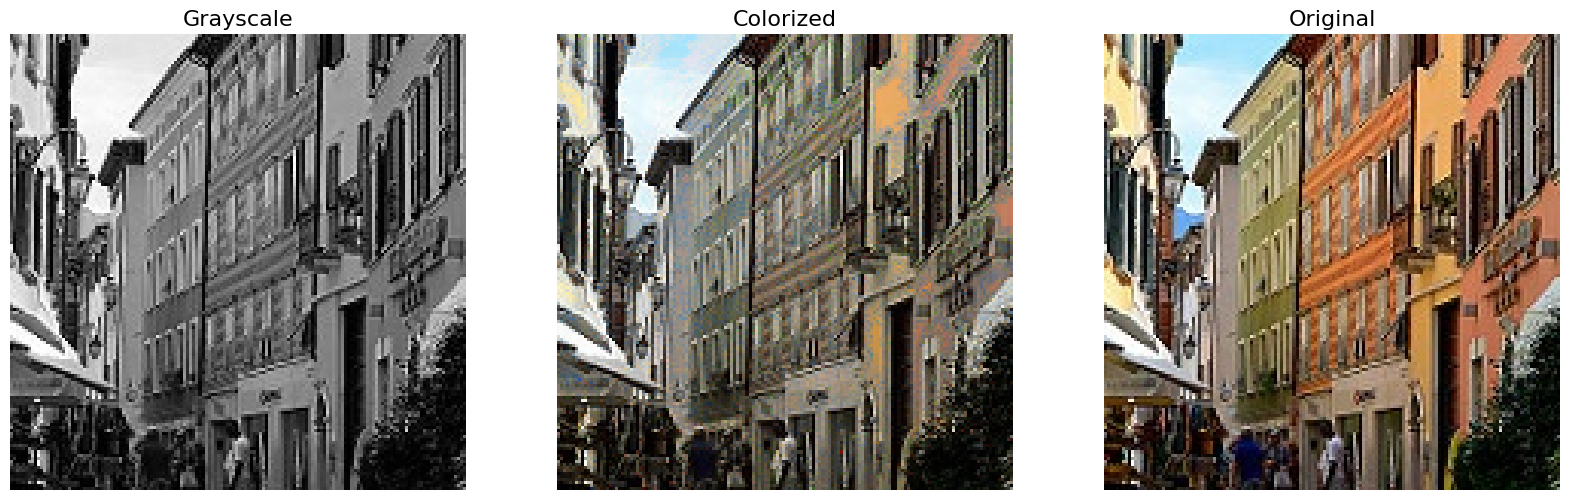

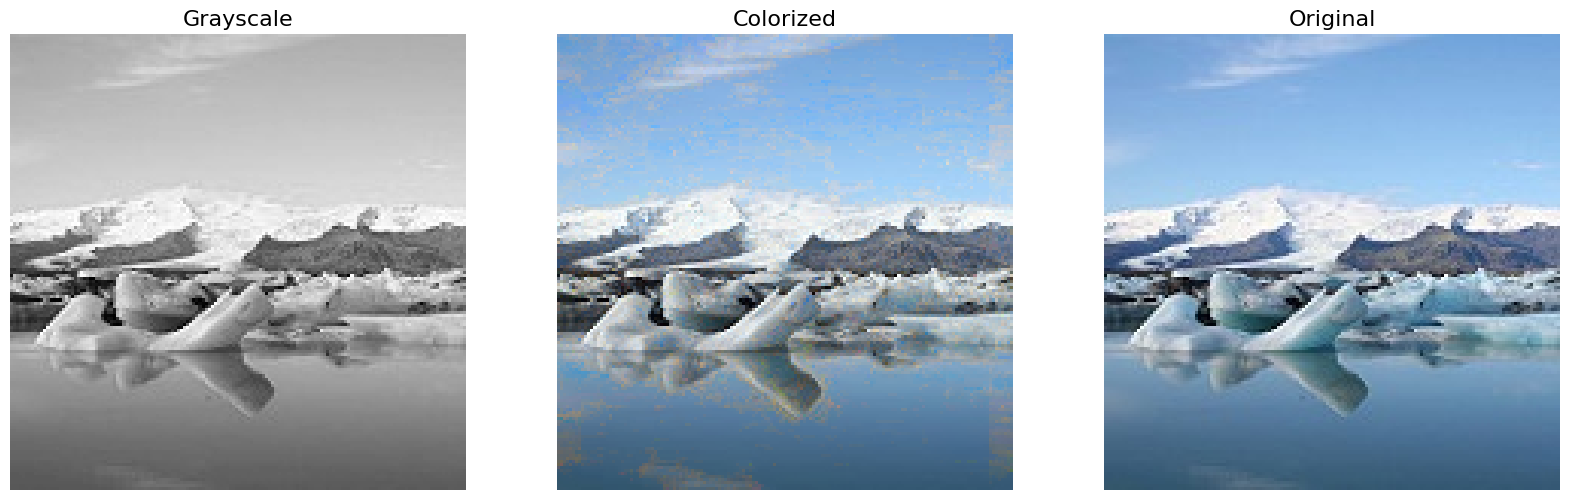

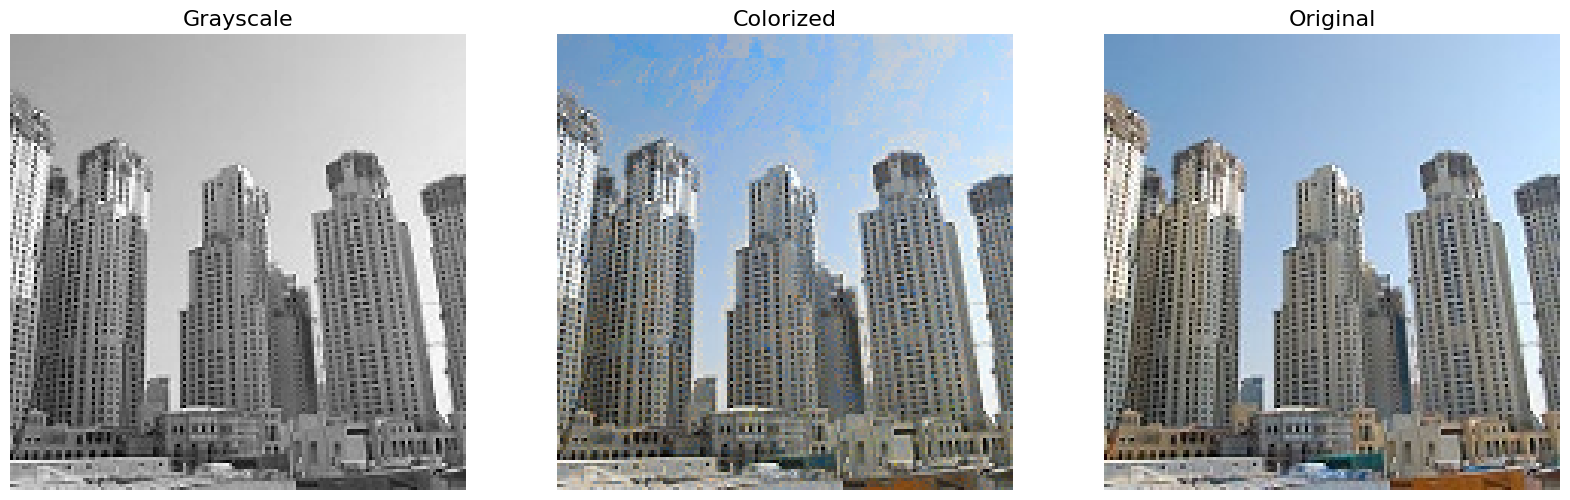

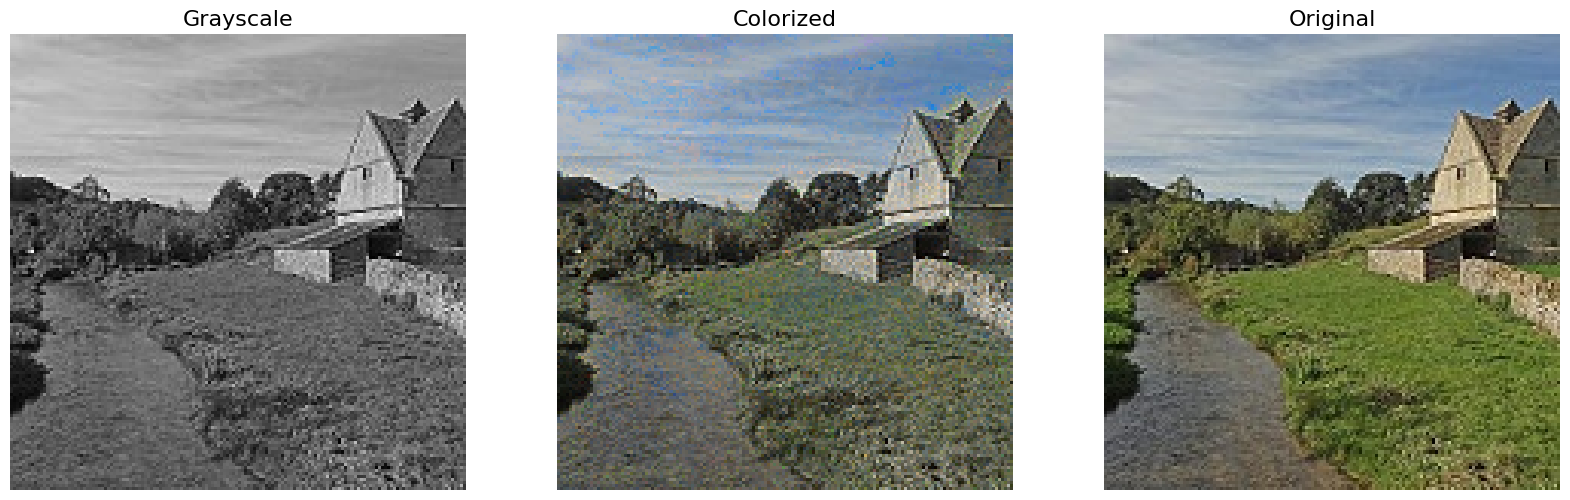

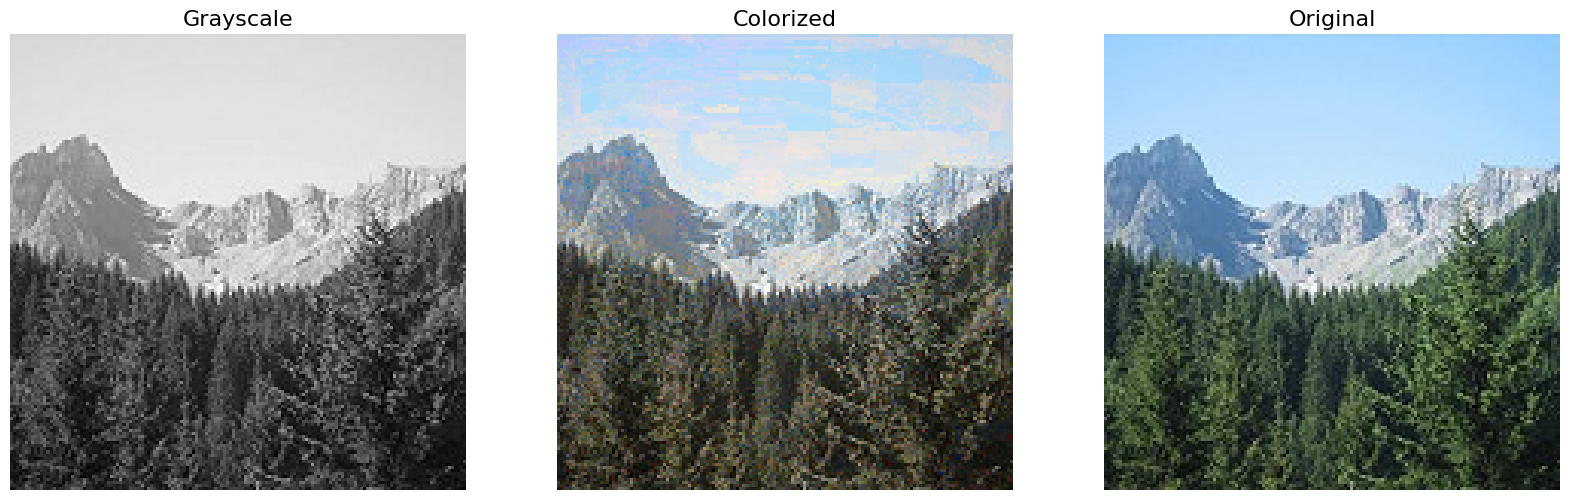

In [205]:
# Testing Colorization:
input_images_path = ["test1.jpg","test2.jpg","test3.jpg","test4.jpg","test5.jpg"]
for input_image_path in input_images_path:
    input_image = cv2.imread(input_image_path)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    grayscale_image = convert_to_grayscale(input_image)
    colorized_image = colorize_image(grayscale_image, knn_model)
    plt.figure(figsize=(20,20))
    gr_image = plt.subplot(1,3,1)
    gr_image.set_title('Grayscale', fontsize=16)
    plt.axis("off")
    plt.imshow( grayscale_image.astype("uint8") , cmap='gray' )


    out_image = plt.subplot(1,3,2)
    out_image.set_title('Colorized', fontsize=16)
    plt.axis("off")
    plt.imshow( colorized_image.astype( 'uint8' ))

    og_image = plt.subplot(1,3,3)
    og_image.set_title('Original', fontsize=16)
    plt.axis("off")
    plt.imshow( input_image.astype( 'uint8' ))
    plt.show()

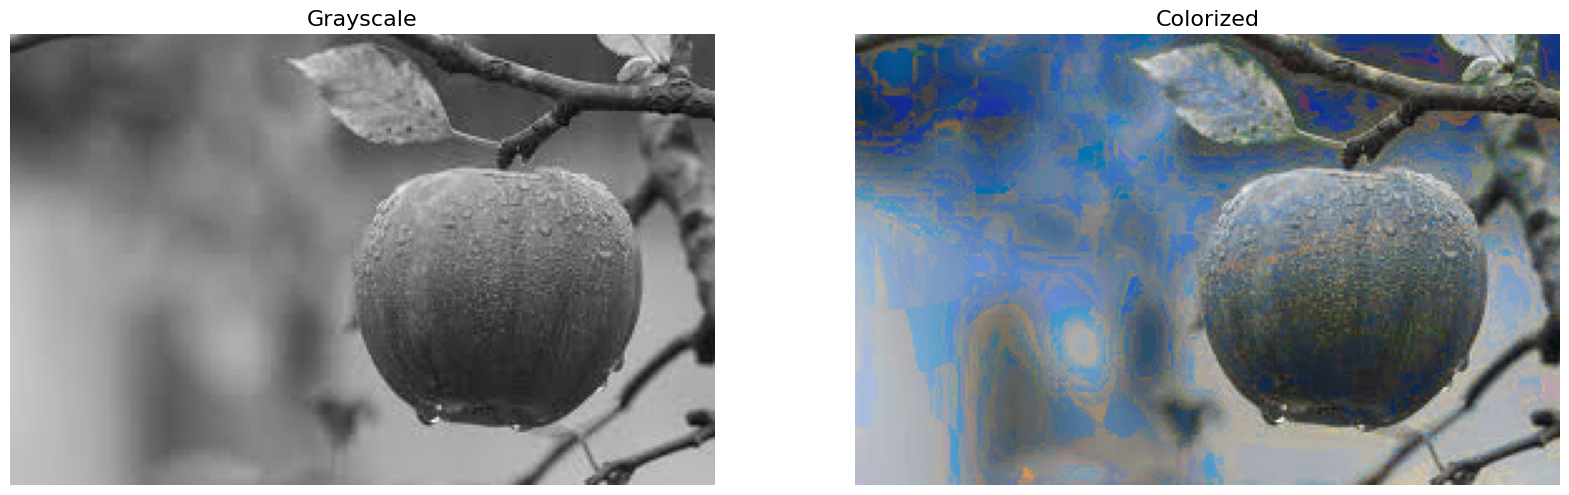

In [207]:
# testing on unseen data
input_image_path = "test.jpg"
input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

colorized_image = colorize_image(input_image, knn_model)
plt.figure(figsize=(20,20))
gr_image = plt.subplot(1,2,1)
gr_image.set_title('Grayscale', fontsize=16)
plt.axis("off")
plt.imshow( input_image , cmap='gray' )


out_image = plt.subplot(1,2,2)
out_image.set_title('Colorized', fontsize=16)
plt.axis("off")
plt.imshow( colorized_image.astype( 'uint8' ))